In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import BaggingClassifier

In [2]:
data_path = 'adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
data = pd.read_csv(data_path, names=column_names, sep = ",", skipinitialspace=True,  header=None)
data["wage_class"] = data["wage_class"].map({"<=50K": 0, ">50K": 1})
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [3]:
data["workclass"] = data["workclass"].replace({"Never-worked": "?", "Without-pay": "?"})
data.sex = data.sex.replace({"Male": 0, "Female": 1})
data.capital_gain = (data.capital_gain > 0).astype(int)
data.capital_loss = (data.capital_loss > 0).astype(int)
data.native_country = (data.native_country == "United-States").astype(int)

C:\Users\mlempicki\AppData\Local\Temp\ipykernel_7988\559932236.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.sex = data.sex.replace({"Male": 0, "Female": 1})


In [4]:
data = data.drop(["education"], axis=1)
data.rename({"native_country": "us_native"}, axis=1, inplace=True)
data = data.drop(["fnlwgt"], axis=1)

In [5]:
data.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,us_native,wage_class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,0,1,0,40,1,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,1,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,1,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,1,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,0,0


In [6]:
X = data.drop(["wage_class"], axis=1)
y = data.wage_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
num_columns = ["age", "education_num", "hours_per_week"]
cat_columns = ["workclass", "marital_status", "occupation", "relationship", "race"]
bin_columns = ["sex", "capital_gain", "capital_loss", "us_native"]

num_pipe = Pipeline([
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

In [8]:
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_columns),
    ("cat", cat_pipe, cat_columns),
    ("bin", "passthrough", bin_columns)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'education_num', 'hours_per_week']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['workclass', 'marital_status', 'occupation',
                                  'relationship', 'race']),
                                ('bin', 'passthrough',
                                 ['sex', 'capital_gain', 'capital_loss',
                                  'us_native'])])

In [9]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education_num',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('bin', 'passthrough',
                                                  ['sex', 'capital_gain',
                                                   'capital_loss',
                                                   'us_native'])])),
                ('model', LogisticRegression())])

In [10]:
pipeline.fit(X_train, y_train)
pipeline.predict(X_test)

array([0, 0, 1, ..., 1, 0, 0])

In [11]:
accuracy_score(y_test, pipeline.predict(X_test))

0.8510670965760786

In [12]:
param_grid = {
    "model__C": np.logspace(-5, 5, 11)
}

cv = KFold(10, shuffle=True)
optimizer = GridSearchCV(pipeline, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
optimizer.fit(X_train, y_train)

print(optimizer.best_params_)

accuracy_score(y_test, optimizer.best_estimator_.predict(X_test))

{'model__C': np.float64(10000.0)}


0.8512206356517734

In [13]:
optimizer.cv_results_["mean_test_score"]

array([0.75929018, 0.75990443, 0.82317212, 0.83891248, 0.84163817,
       0.84236755, 0.84217561, 0.84221397, 0.8421756 , 0.8426363 ,
       0.84240594])

In [14]:
pipelne_new = deepcopy(pipeline)

In [15]:
cv = KFold(10, shuffle=True)
optimizer = GridSearchCV(pipeline, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)
optimizer.fit(X_train, y_train)

print(optimizer.best_params_)

{'model__C': np.float64(1.0)}


In [16]:
y_probs = optimizer.best_estimator_.predict_proba(X_test)[:, 1] # prawdopodobieństwa jedynek

roc_auc_score(y_test, y_probs)

np.float64(0.900774573853647)

In [17]:
accuracy_score(y_test, y_probs>0.5), precision_score(y_test, y_probs>0.5)

(0.8510670965760786, np.float64(0.7331264546159814))

In [18]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

cv = KFold(10, shuffle=True)
optimizer = GridSearchCV(pipeline, param_grid, cv=cv, scoring=ftwo_scorer, n_jobs=-1)

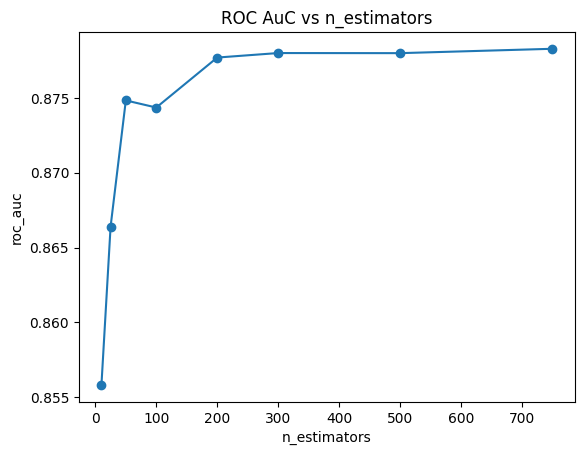

In [19]:
n_estimators = [10, 25, 50, 100, 200, 300, 500, 750]

estimators_roc_auc = []
for n in n_estimators:
    model = BaggingClassifier(None, n, n_jobs=-1)
    pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model),
        ],
    )
    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    estimators_roc_auc.append(roc_auc_score(y_test, y_probs))

plt.plot(n_estimators, estimators_roc_auc, label="n_estimators", marker="o")
plt.xlabel("n_estimators")
plt.ylabel("roc_auc")
plt.title("ROC AuC vs n_estimators")
plt.show()

#### Wynik nie jest deterministyczny, jest tu element losowości przy kolejnym uruchomieniu, bez ustawiania ziaren

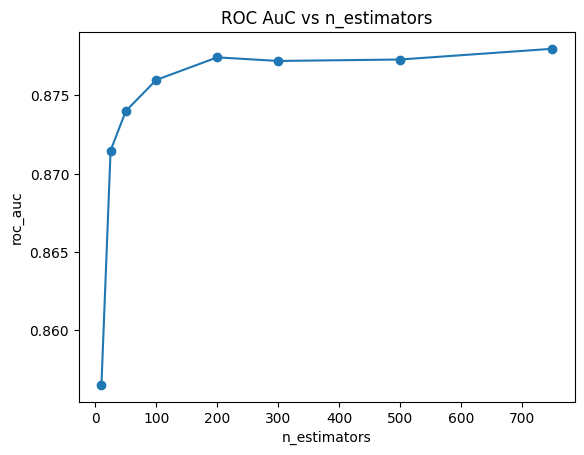

In [20]:
n_estimators = [10, 25, 50, 100, 200, 300, 500, 750]

estimators_roc_auc = []
for n in n_estimators:
    model = BaggingClassifier(None, n, n_jobs=-1)
    # optymalizacja: nie powielać transforamcji danych, preprocessor się nie zmienia
    pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model),
        ],
    )
    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    estimators_roc_auc.append(roc_auc_score(y_test, y_probs))

plt.plot(n_estimators, estimators_roc_auc, label="n_estimators", marker="o")
plt.xlabel("n_estimators")
plt.ylabel("roc_auc")
plt.title("ROC AuC vs n_estimators")
plt.show()

In [21]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

n_estimators = [10, 25, 50, 100, 200, 300, 500, 750]

estimators_roc_auc = []
for n in n_estimators:
    model = BaggingClassifier(None, n, n_jobs=-1)
    model.fit(X_train_transformed, y_train)
    y_probs = pipeline.predict_proba(X_test_transformed)[:, 1]
    estimators_roc_auc.append(roc_auc_score(y_test, y_probs))

plt.plot(n_estimators, estimators_roc_auc, label="n_estimators", marker="o")
plt.xlabel("n_estimators")
plt.ylabel("roc_auc")
plt.title("ROC AuC vs n_estimators")
plt.show()

ValueError: X has 42 features, but ColumnTransformer is expecting 12 features as input.